# Preparations

Import various libraries: Mainly Tensorflow & Keras

In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
import matplotlib.pylab as plot
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

Using TensorFlow backend.


Setting some general values.

In [2]:
IMG_HEIGHT = 50
IMG_WIDTH = 50

BATCH_SIZE_TRAIN = 10
BATCH_SIZE_VAL = 10
EPOCHS = 20

# Load the Images

First we load the classified images.

In [3]:
dataset_dir = './dataset/'

img_gen = ImageDataGenerator(
    rescale = 1./255, # Rescale [0, 255] to [0, 1] because NN prefer smaller input
    horizontal_flip = True, # Randomly flip inputs horizontally
    vertical_flip = True, # Randomly flips inputs vertically
    rotation_range=90, # Randomly rotates input
    height_shift_range = .2,
    validation_split = 0.2 # mark 20% as belonging to the validation set
)

train_gen = img_gen.flow_from_directory(
    dataset_dir,
    batch_size=BATCH_SIZE_TRAIN,
    shuffle = True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    subset = 'training'
)

val_gen = img_gen.flow_from_directory(
    dataset_dir,
    batch_size=BATCH_SIZE_VAL,
    shuffle = True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical',
    subset = 'validation'
)


Found 4800 images belonging to 5 classes.
Found 1200 images belonging to 5 classes.


We have 6000 images in total.
They have now been split up in training and validation sets (that are strictly not overlapping)

# Create the model

This is the part that has to be optimized the most! (and isn't at all yet)

In [4]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(5, activation='sigmoid')
])

# Compile the model

In [5]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)         

In [6]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=BATCH_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=BATCH_SIZE_VAL
)

Epoch 1/20
10/10 [==============================] - 2s 202ms/step - loss: 0.5586 - accuracy: 0.7740 - val_loss: 0.5245 - val_accuracy: 0.8000
Epoch 2/20
10/10 [==============================] - 1s 50ms/step - loss: 0.5300 - accuracy: 0.8000 - val_loss: 0.5103 - val_accuracy: 0.8000
Epoch 3/20
10/10 [==============================] - 0s 47ms/step - loss: 0.5100 - accuracy: 0.8000 - val_loss: 0.5108 - val_accuracy: 0.8000
Epoch 4/20
10/10 [==============================] - 0s 47ms/step - loss: 0.5020 - accuracy: 0.8000 - val_loss: 0.5127 - val_accuracy: 0.8000
Epoch 5/20
10/10 [==============================] - 0s 47ms/step - loss: 0.5031 - accuracy: 0.8000 - val_loss: 0.4767 - val_accuracy: 0.8000
Epoch 6/20
10/10 [==============================] - 0s 48ms/step - loss: 0.4950 - accuracy: 0.8000 - val_loss: 0.5238 - val_accuracy: 0.8000
Epoch 7/20
10/10 [==============================] - 1s 50ms/step - loss: 0.4879 - accuracy: 0.8000 - val_loss: 0.4854 - val_accuracy: 0.8000
Epoch 8/20
1

Evaluating the result

In [7]:
scores = model.evaluate_generator(val_gen, steps=BATCH_SIZE_VAL)
print("Model Test Loss:" , scores[0])
print("Model Test Accuracy:", scores[1])

Model Test Loss: 0.3430069386959076
Model Test Accuracy: 0.8920000195503235


# Saving the model

We're using the SavedModel format as that also saves all of the weights 

In [8]:
model_name = "akt-model"

model.save(model_name + ".h5")
# can be loaded again with
# from keras.models import load_model
# model = load_model(model_name + ".h5")

# Evaluating the model

The following few steps will output different information about the model

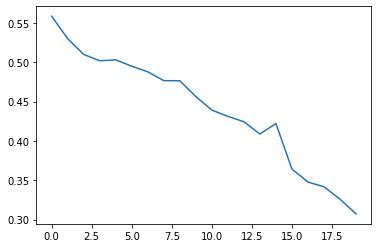

In [9]:
plot.plot(history.history['loss'])

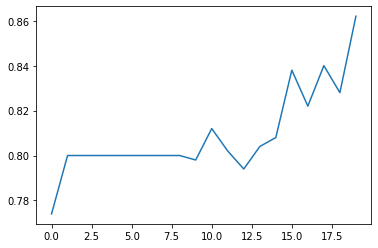

In [10]:
plot.plot(history.history['accuracy'])

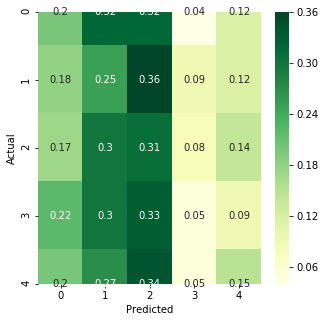

In [11]:
predictions = model.predict_generator(val_gen)

confusion_predicts = list(map(lambda p: np.argmax(p), predictions))

con_mat = tf.math.confusion_matrix(val_gen.labels, confusion_predicts, 5).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index = [0, 1, 2, 3, 4], columns = [0, 1, 2, 3, 4])
plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.YlGn)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()